# Projet MCS :  Détection d'activité humaine - DTW et classification avec réduction de dimension

**Nom du Groupe :**

**Noms :*KALMOGO*

**Prénoms :*Benjamin*

**Noms :*YASSINE*

**Prénoms :*Safaa*


Dans ce projet, nous essaierons de prédire l'activité humaine (1-Descendre, 2-Courir, 3-Assis, 4-Debout, 5-Monter ou 6-Marcher) en utilisant les capteurs du smartphone. C'est-à-dire qu'en utilisant les méthodes suivantes, le smartphone peut détecter ce que nous faisons en ce moment.


En utilisant l'accéléromètre  intégré dans le smartphone,  l'accélération linéaire 3-axes à un taux constant de 50Hz ont été relevées. Les expériences ont été enregistrées sur vidéo pour étiqueter les données manuellement. 

<img src="files/HARDataset.JPG" width="800" height="600"  >

Il est fourni pour chaque enregistrement de l'ensemble de données : 
- L'accélération triaxiale de l'accéléromètre (accélération totale) et l'accélération estimée du corps. 
- Son étiquette d'activité. 
- Un identifiant du sujet qui a réalisé l'expérience.


Ces 5 séances se décomposent en 4 parties : 
- Partie I : DTW et application du TD
- Partie II : Système de reconnaissance d'activité physique avec la DTW
- Partie III : Comparaison de la programmation dynamique avec une méthode de classification après prétraitement des données par ACP
- Partie IV : Votre étude

**Travail à rendre**

Pour cela, vous devez par binômes (effectif **OBLIGATOIRE**):
1. Implémenter la DTW, tester les exercices de TD;
3. Utilser la DTW pour créer un système de reconnaissance;
4. Evaluer les résultats en utilisant la matrice de confusion et le pourcentage de bonne classification;
5. Implémenter l'ACP et les kppv 
6. Rédiger un rapport en pdf présentant votre étude : les résultats par les 2 méthodes et vos commentaires et conclusions sur une étude plus générale en modifiant les tailles des ensembles de test et d'apprentissage, en changeant le nombre de classes  (Longeur max. : 10 pages).


**Dataset et description :**
https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+





In [11]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns

In [12]:
# Paramètres du dataset
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

# LABELS = [
#     'Downstairs',
#     'Jogging',
#     'Sitting',
#     'Standing',
#     'Upstairs',
#     'Walking'
# ]


LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
 
]


DATA_PATH = './WISDM_ar_v1.1_raw.txt'


# Durée des profils temporels
TIME_STEP = 60

# Paramètres
N_CLASSES = 3
#N_CLASSES = 3
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_TIME_SIZE =30
TAILLE_TEST=50
TAILLE_APP=15
# TAILLE_TEST=100
# TAILLE_APP=500

## 1. Chargement des données d'apprentissage et de test

Convoluted data shape:  (8376, 30, 3)
Labels shape: (8376,)
(8376, 30, 3)
Classe N° 0
Classe N° 1
Classe N° 2
(45, 90)
(150, 90)


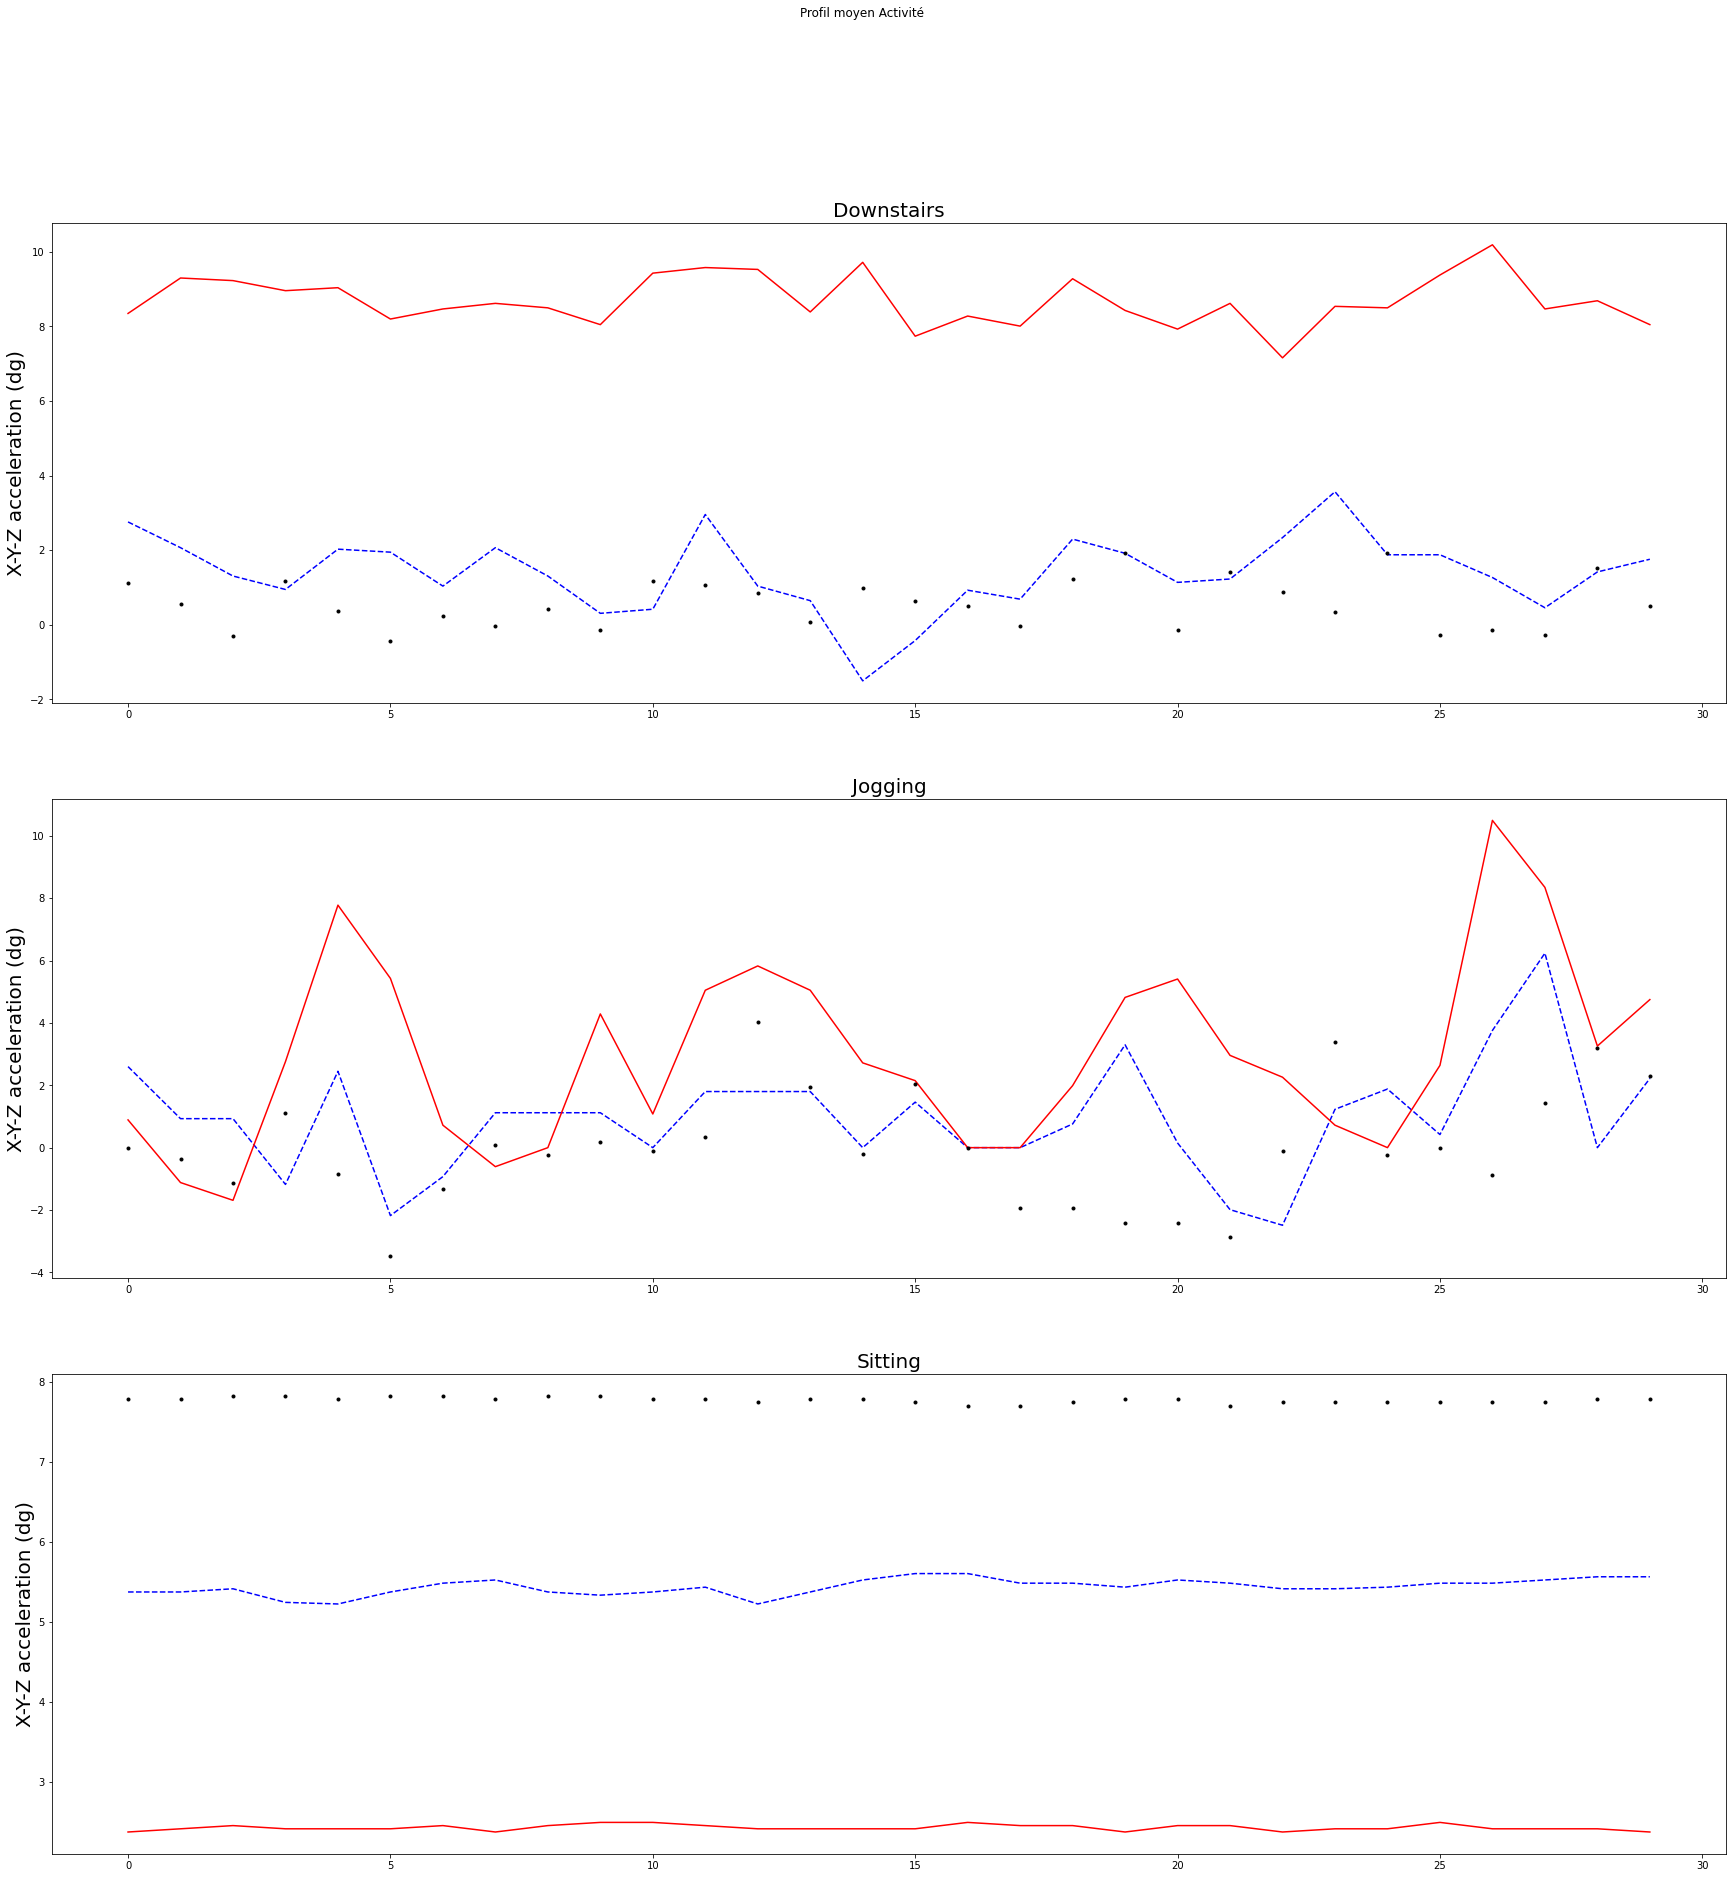

In [13]:
# LOAD DATA
from sklearn.preprocessing import  RobustScaler

data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()
  
# DATA PREPROCESSING
data_convoluted = []
labels = []



# Slide a "SEGMENT_TIME_SIZE" wide window with a step size of "TIME_STEP"
for j in range(0,N_CLASSES):
    DataBest=data[data['activity'] == LABELS[j]]
    for i in range(0, len(DataBest) - SEGMENT_TIME_SIZE, TIME_STEP):
        x = DataBest['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
        y = DataBest['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
        z = DataBest['z-axis'].values[i: i + SEGMENT_TIME_SIZE]

        data_convoluted.append([x, y, z])
    # Label for a data window is the label that appears most commonly
        label = j
        labels.append(label)


# Convert to numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

# One-hot encoding
labels = np.asarray(labels, dtype=np.int)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)

# Plot activity curves
print(data_convoluted.shape)

fig, axs = plt.subplots(N_CLASSES,figsize=(30,30))
fig.suptitle('Profil moyen Activité')

profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_Data_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)

for i in range(N_CLASSES):
    # Selection des données correspondant à la classe i
    print('Classe N°',i)
    res=np.where(labels==i)
    res=np.array(res)
    res=np.ravel(res)
    taille=res.shape[0]
    
    # Création de la base de Test
    tirage=np.random.randint(0,taille,TAILLE_TEST)
    List_Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=res[tirage[0:TAILLE_TEST]]
    Label_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=i
    tir_dataTest=data_convoluted[res[tirage[0:TAILLE_TEST]],:,:]
    Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST,:]=np.reshape(tir_dataTest,(TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
    
    #Normalisation de la base de test
    Data_Test = RobustScaler().fit_transform(Data_Test)
#         y = RobustScaler().fit_transform(y)
#         z = RobustScaler().fit_transform(z)
    
    # Création de la base d'Apprentissage
    tirage1=np.random.randint(0,taille,TAILLE_APP)
    tir_dataApp=data_convoluted[res[tirage1[0:TAILLE_APP]],:,:]
    Data_App[i*TAILLE_APP:(i+1)*TAILLE_APP,:]=np.reshape(tir_dataApp,(TAILLE_APP,SEGMENT_TIME_SIZE*N_FEATURES))
    Label_App[i*TAILLE_APP:(i+1)*TAILLE_APP]=i
    
    #Normalisation de la base d'Apprentissage
    Data_App = RobustScaler().fit_transform(Data_App)
    
    #
    
    
    # Affichage du profil temporel moyen de la classe
    class1=np.median(tir_dataApp,axis=0)
    profil_moyen[i,:,:]=class1
    
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,0],'b--')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,1],'r-')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,2],'k.')
    axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
    axs[i].set_title(LABELS[i], fontsize=20)

print(Data_App.shape)
print(Data_Test.shape)


# Partie I : Implémentation de l'algorithme de programmation dynamique 

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD. 

2. Afin d'adapter facilement le calcul des coûts suivant la nature des données (et donc des distances utilisées), écrivez une fonction pour chaque distance (euclidienne, lettres, sons) qui apparaîtra en paramètre de la fonction DTW.

In [7]:


from math import *
import numpy as np
import sys

#j'ai modifie les wi qui a linitiale eatit en 1
# w1=0.5
# w2=0.5
# w3=0.5
w1=1
w2=1
w3=1

def DTW(A, B, window = sys.maxsize, d = lambda x,y: np.linalg.norm((x-y))):
    # create the cost matrix
    A= np.array(A)
    B= np.array(B)
    M= len(A)
    N= len(B)
    cost = np.ones((M, N))

    # initialize the first row and column
    cost[0, 0] = d(A[0], B[0])
    for i in range(1, M):
        cost[i, 0] = cost[i-1, 0] + d(A[i], B[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j-1] + d(A[0], B[j])
    # fill in the rest of the matrix
    for i in range(1, M):
        for j in range(max(1, i - window), min(N, i + window)):
            choices = w2*cost[i - 1, j - 1], w1*cost[i, j-1], w3*cost[i-1, j]
            cost[i, j] = min(choices) + d(A[i], B[j])

    # find the optimal path
    n, m = N - 1, M - 1
    path = []

    while (m, n) != (0, 0):
        path.append((m, n))
        m, n = min((m - 1, n), (m, n - 1), (m - 1, n - 1), key = lambda x: cost[x[0], x[1]])
    
    path.append((0,0))
    return cost[-1, -1]/(N+M), path


In [27]:
np.linalg.norm((1-5))

4.0

### Application aux exercices 

 Testez vos programmes sur les exercices vus en TD. 



Score DTW entre les 2 séquences :  3.6


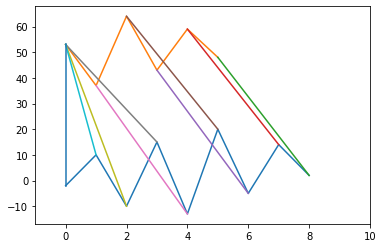

In [28]:
# Test sur exos de TD
# Exercice 1
A=np.array([-2,10,-10,15,-13,20,-5,14,2])
B=np.array([3,-13,14,-7,9,-2])

cost, path = DTW(A, B, window = max(len(A),len(B)))
print('Score DTW entre les 2 séquences : ', cost)
    
offset = 50
plt.xlim([-1, max(len(A), len(B)) + 1])
plt.plot(A)
plt.plot(B+offset)
for (x1, x2) in path:
    plt.plot([x1, x2], [A[x1], B[x2] + offset])
plt.show()




(<Figure size 720x720 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

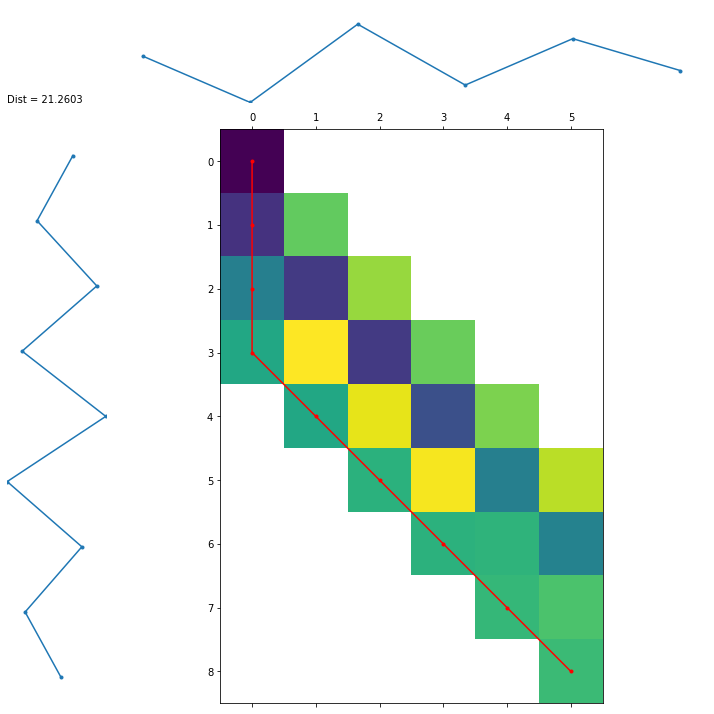

In [3]:
!pip install dtaidistance
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
A=np.array([-2,10,-10,15,-13,20,-5,14,2])
B=np.array([3,-13,14,-7,9,-2])
random.seed(1)
for idx in range(len(B)):
    if random.random() < 0.05:
        A[idx] += (random.random() - 0.5) / 2
d, paths = dtw.warping_paths(A, B, window=1)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(A, B, paths, best_path)

# Partie II : Système de reconnaissance d'activité physique avec la DTW



Pour chaque profil temporel test,
- Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe 
- Déterminer la classe d'appartenance par minimum du score sur toutes les classes



In [29]:

print(TAILLE_TEST)
PartitionDTW=np.zeros((TAILLE_TEST*N_CLASSES,2))

for num in range(TAILLE_TEST*N_CLASSES):

    result=np.zeros(N_CLASSES)
    for i in range(N_CLASSES):
        val=int(List_Data_Test[num])

        cost,path =DTW(data_convoluted[val,:,:],profil_moyen[i,:,:])
        result[i]=cost
        index=np.argmin(result)
        PartitionDTW[num,0]=index
        PartitionDTW[num,1]=Label_Test[num]
        
        


50


## Evaluation des résultats de la DTW

A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

Matrice de confusion par DTW
Accuracy sur base de test : 0.8


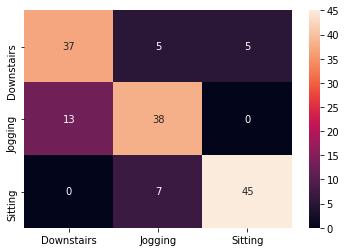

In [30]:


from sklearn.metrics import accuracy_score , classification_report
from sklearn.metrics import confusion_matrix

print('Matrice de confusion par DTW')
cm=confusion_matrix(PartitionDTW[:,0],PartitionDTW[:,1])
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS),yticklabels=np.unique(LABELS),annot=True)

# score de performance
print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

In [31]:
# mesure de performance
print(classification_report(PartitionDTW[:,1],PartitionDTW[:,0] , target_names=LABELS))


              precision    recall  f1-score   support

  Downstairs       0.79      0.74      0.76        50
     Jogging       0.75      0.76      0.75        50
     Sitting       0.87      0.90      0.88        50

    accuracy                           0.80       150
   macro avg       0.80      0.80      0.80       150
weighted avg       0.80      0.80      0.80       150



## Amélioration du modèle
On cherche les meilleurs valeurs pour les poids wi

In [17]:
from math import *
import numpy as np
import sys

#On ajoute les poids comme paramètres du modèle

def DTW(A, B, weights,window = sys.maxsize, d = lambda x,y: np.linalg.norm((x-y)) ):  
    w1=weights[0]
    w2=weights[1]
    w3=weights[2]
    # create the cost matrix
    A= np.array(A)
    B= np.array(B)
    M= len(A)
    N= len(B)
    cost = np.ones((M, N))

    # initialize the first row and column
    cost[0, 0] = d(A[0], B[0])
    for i in range(1, M):
        cost[i, 0] = cost[i-1, 0] + d(A[i], B[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j-1] + d(A[0], B[j])
    # fill in the rest of the matrix
    for i in range(1, M):
        for j in range(max(1, i - window), min(N, i + window)):
            choices = w2*cost[i - 1, j - 1], w1*cost[i, j-1], w3*cost[i-1, j]
            cost[i, j] = min(choices) + d(A[i], B[j])

    # find the optimal path
    n, m = N - 1, M - 1
    path = []

    while (m, n) != (0, 0):
        path.append((m, n))
        m, n = min((m - 1, n), (m, n - 1), (m - 1, n - 1), key = lambda x: cost[x[0], x[1]])
    
    path.append((0,0))
    return cost[-1, -1]/(N+M), path


In [18]:
from sklearn.metrics import accuracy_score

def weights(A, B, window = sys.maxsize, d = lambda x,y: np.linalg.norm((x-y))):
  PartitionDTW=np.zeros((TAILLE_TEST*N_CLASSES,2))
  Maxscore = 0
  best = []
  weights = [0,0,0]
  for  i in range(4):
    weights[0] = i + 1
    for j in range(4):
      weights[1] = j + 1
      for k in range(4):
        weights[2] = k + 1
        for num in range(TAILLE_TEST*N_CLASSES):
          result=np.zeros(N_CLASSES)
          for i in range(N_CLASSES):
              val=int(List_Data_Test[num])
              cost,path =DTW(data_convoluted[val,:,:],profil_moyen[i,:,:], weights)
              result[i]=cost
              index=np.argmin(result)
              PartitionDTW[num,0]=index
              PartitionDTW[num,1]=Label_Test[num]
        score = accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1])
        if  score > Maxscore :
          Maxscore =  score
          best = weights[:]
        print("poids:",weights,"nouveau score :",score, "Meilleur:" ,best, Maxscore)
  return best

In [19]:
weight =  weights(data_convoluted,profil_moyen)

poids: [1, 1, 1] nouveau score : 0.82 Meilleur: [1, 1, 1] 0.82
poids: [1, 1, 2] nouveau score : 0.7866666666666666 Meilleur: [1, 1, 1] 0.82
poids: [1, 1, 3] nouveau score : 0.7866666666666666 Meilleur: [1, 1, 1] 0.82
poids: [1, 1, 4] nouveau score : 0.7866666666666666 Meilleur: [1, 1, 1] 0.82
poids: [1, 2, 1] nouveau score : 0.74 Meilleur: [1, 1, 1] 0.82
poids: [1, 2, 2] nouveau score : 0.7533333333333333 Meilleur: [1, 1, 1] 0.82
poids: [1, 2, 3] nouveau score : 0.7533333333333333 Meilleur: [1, 1, 1] 0.82
poids: [1, 2, 4] nouveau score : 0.7533333333333333 Meilleur: [1, 1, 1] 0.82
poids: [1, 3, 1] nouveau score : 0.74 Meilleur: [1, 1, 1] 0.82
poids: [1, 3, 2] nouveau score : 0.7533333333333333 Meilleur: [1, 1, 1] 0.82
poids: [1, 3, 3] nouveau score : 0.7533333333333333 Meilleur: [1, 1, 1] 0.82
poids: [1, 3, 4] nouveau score : 0.7533333333333333 Meilleur: [1, 1, 1] 0.82
poids: [1, 4, 1] nouveau score : 0.74 Meilleur: [1, 1, 1] 0.82
poids: [1, 4, 2] nouveau score : 0.7533333333333333 Mei

# Partie III : Comparaison de la programmation dynamique avec une méthode de classification après prétraitement des données

Dans cette partie, nous allons comparer les résultats de la DTW avec ceux d'une méthode de classification de données : les k-plus proches voisins.

Nous utiliserons les fonctions permettant de calculer l'ACP et les kppv via la librairie python *scikit-learn*.





In [32]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D

### Prétraitement par ACP

Pour tester une autre méthode de classification, 

1. A partir des données Data_App de la base d'apprentissage et en utilisant la fonction *PCA* de la librairie *scikit-learn*, calculez les 3 axes principaux de l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$.Ces vecteurs propres constitueront la nouvelle base de données.

2. Projetez les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque
vecteur par la base $P = [X_1X_2X_3]$.

*Remarque :* vous pouvez aussi implémenter l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$ (par les fonctions *np.cov* et *np.linalg.eig*). Ces vecteurs propres constitueront le nouveau repère P.  Projetez ensuite les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque vecteur par la base $P = [X_1X_2X_3]$.




Dimension Base Apprentissage (45, 90)
(90, 45)
Dimension S (90, 90)


<ipython-input-33-4d2f2b8c9bf3>:17: ComplexWarning: Casting complex values to real discards the imaginary part
  principalAxes[:,i]=eig_vecs[:,i]


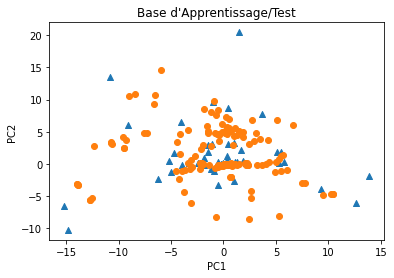

Contraste : (0.6090232685748649+0j)
0.6090232685748642


In [33]:

from sklearn.decomposition import PCA

n_components=2
print('Dimension Base Apprentissage',Data_App.shape)
#print(Data_Test.shape)

# En implémentant l'ACP 
T=np.transpose(Data_App)
print(T.shape)
cov_mat=np.cov(np.transpose(Data_App))
print('Dimension S',cov_mat.shape)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

principalAxes=np.zeros((Data_App.shape[1],n_components))
for i in range(n_components):
    principalAxes[:,i]=eig_vecs[:,i]

principalComponentsApp = Data_App.dot(principalAxes)
principalComponentsTest = Data_Test.dot(principalAxes)

# affichage des points
#for i in range(0,N_CLASSES*TAILLE_APP):
plt.scatter(principalComponentsApp[:, 0], principalComponentsApp[:, 1],marker='^')
plt.scatter(principalComponentsTest[:, 0], principalComponentsTest[:, 1],marker='o')
plt.title("Base d'Apprentissage/Test")
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.show()


# Pourcentage d'information conservée
Contraste=sum(eig_vals[range(n_components)])/sum(eig_vals)
print("Contraste :", Contraste)

# En utilisant sklearn    
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

# Conservation de l'information : Variance 
print(sum(pca.explained_variance_ratio_))



### Classification par k plus proches voisins

En intelligence artificielle, la méthode des k plus proches voisins (k-ppv) est une méthode d'apprentissage
supervisé. Dans ce cadre, on dispose d'une base de données d'apprentissage constituée de couples  "donnée-label". Pour estimer la sortie associée à une nouvelle entrée x, la méthode des k plus proches voisins consiste à prendre
en compte (de façon identique) les k échantillons d'apprentissage dont l'entrée est la plus proche de la nouvelle
entrée x, selon une distance à définir. L'algorithme 1 associé et un exemple (figure 1) sont données par la suite.

<img src="files/AlgoKppv.png" width="900" height="800"  >

<img src="files/kppv.png" width="300" height="300"  >

**Exemple de classification par k-ppv.** L'échantillon de test (cercle vert) doit être classé soit dans la première
classe des carrés bleus, soit dans la deuxième classe des triangles rouges. 
Si k = 3 (cercle plein), il est assigné à la deuxième classe parce qu'il y a 2 triangles et seulement 1 carré à l'intérieur du cercle intérieur. 
Si k = 5 (cercle en pointillés), il est assigné à la première classe (3 carrés contre 2 triangles à l'intérieur du cercle extérieur)


1. En utilisant la fonction *KNeighborsClassifier* de la librairie *sklearn.neighbors*, réalisez une classification par k-ppv sur la base d'apprentissage et la base de test que vous avez prédéfinies (prendre $k=1$).

2. Evaluez la méthode des k-ppv par le calcul de la matrice de confusion et du taux de reconnaissance.

3. Modifiez la valeur de $k$ pour les k-ppv. Améliorez-vous les scores de reconnaissance ?

4. Comparez vos résultats avec ceux de la DTW.




In [34]:
from sklearn.model_selection import GridSearchCV , StratifiedKFold
param_grid = {'n_neighbors': np.arange(1, 20),
              'metric': ['euclidean', 'manhattan','minkowski']}

#cv=StratifiedKFold(15)

StandardScaler

cv=StratifiedKFold(2)
grid = GridSearchCV(KNeighborsClassifier(), param_grid,scoring='accuracy', cv=cv,)

grid.fit(principalComponentsApp, Label_App)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='accuracy')

In [35]:
print(grid.best_score_)
print(grid.best_params_)


0.7114624505928854
{'metric': 'euclidean', 'n_neighbors': 1}


In [36]:
principalComponentsTest

array([[  3.74294108,  -3.6734922 ],
       [ -1.22364016,  -1.40597519],
       [  2.45712404,  -1.74353616],
       [ -5.95926207,  -2.43694648],
       [ -1.16111892,  -1.30810005],
       [  0.05821428,  -1.47973071],
       [ -0.30817324,  -1.629218  ],
       [ -3.65118771,  -1.47421513],
       [ -1.21374682,  -1.44554056],
       [  2.6910418 ,  -2.05407762],
       [ -1.42214168,  -1.34977033],
       [  0.26858545,  -2.03384576],
       [ -2.83702628,  -1.46578005],
       [ -1.03669921,  -1.30642022],
       [ -1.37486909,  -1.35311225],
       [ -4.13680727,  -1.53069941],
       [  2.58018354,  -1.85986569],
       [  3.17859012,  -2.26719791],
       [ -0.92139646,  -1.5601936 ],
       [ -1.37863098,  -1.45385328],
       [ -0.1989676 ,  -1.70438478],
       [ -0.01730485,  -1.76092659],
       [ -2.53104155,  -1.26001916],
       [ -2.69490599,  -1.17411675],
       [ -1.80150651,  -1.48882822],
       [  0.85704922,  -1.54497455],
       [ -0.53131085,  -1.33920185],
 

In [37]:
model = grid.best_estimator_
model.score(principalComponentsTest, Label_Test)

0.8733333333333333

In [38]:
# from sklearn.model_selection import learning_curve

# model=KNeighborsClassifier()
# N, train_score, val_score = learning_curve(model, principalComponentsApp, Label_App,
#                                            train_sizes=np.linspace(0.1, 1, 10), cv=3)

# print(N)
# plt.plot(N, train_score.mean(axis=1), label='train')
# plt.plot(N, val_score.mean(axis=1), label='validation')
# plt.xlabel('train_sizes')
# plt.legend()

Matrice de confusion avec ACP+kNN
Accuracy sur base de test : 0.8733333333333333


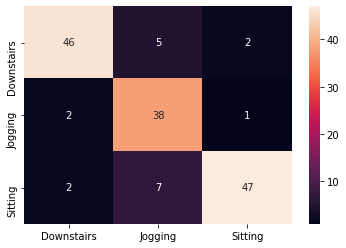

In [39]:


knn = grid.best_estimator_

pred_i = knn.predict(principalComponentsTest)

# Evaluation des résultats par matrices de confusion 
print('Matrice de confusion avec ACP+kNN')
cm=confusion_matrix(pred_i,Label_Test)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS),yticklabels=np.unique(LABELS),annot=True)

# score de performance
print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))


In [40]:
# mesure de performance
print(classification_report(Label_Test,pred_i , target_names=LABELS))

              precision    recall  f1-score   support

  Downstairs       0.87      0.92      0.89        50
     Jogging       0.93      0.76      0.84        50
     Sitting       0.84      0.94      0.89        50

    accuracy                           0.87       150
   macro avg       0.88      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150

